In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, recall_score, f1_score, roc_auc_score, precision_score, RocCurveDisplay
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Data Preprocess

In [4]:
target = "Churn"

df["TotalCharges"] = df["TotalCharges"].apply(lambda row: row.replace(" ", "0"))
df["TotalCharges"] = df["TotalCharges"].apply(lambda row: float(row.format(".2f")))

df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']] = df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')
df["MultipleLines"]= df["MultipleLines"].replace("No phone service", "No")

cols = df.columns

cat_cols = [col for col in cols if df[col].dtype == "O" and df[col].nunique() < 10]
num_cols = [col for col in cols if df[col].dtype != "O"]
num_but_cat = [col for col in num_cols if col in num_cols and df[col].nunique() < 10]

cat_cols = cat_cols + num_but_cat
num_cols = [col for col in num_cols if col not in num_but_cat]

binary_cols = [col for col in cols if df[col].nunique() == 2]
ohe_cols = [col for col in cat_cols if df[col].nunique() > 2]

cat_cols.remove(target)

print("Categorical_cols: ", cat_cols)
print("Numerical cols: ", num_cols)
print("Binary cols: ", binary_cols)
print("Ohe_cols: ", ohe_cols)

Categorical_cols:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']
Numerical cols:  ['tenure', 'MonthlyCharges', 'TotalCharges']
Binary cols:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
Ohe_cols:  ['InternetService', 'Contract', 'PaymentMethod']


# Pipeline

In [5]:
# Base model(without scaling)

models = [("LR", LogisticRegression()),
         ("KNN", KNeighborsClassifier()),
         ("CART", DecisionTreeClassifier()),
         ("RF", RandomForestClassifier()),
         ("GBM", GradientBoostingClassifier()),
         ("XGB", XGBClassifier()),
         ("LGBM", LGBMClassifier(verbose=0)),
         ("ADA", AdaBoostClassifier()),
         ("CatBoost", CatBoostClassifier(verbose=False))
          ]
for col in binary_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

transformer = ColumnTransformer([("OHE", OneHotEncoder(drop="if_binary"), ohe_cols)], 
                                remainder="passthrough")

X = df.drop([target, "customerID"], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

for name, model in models:
    
    pipe = Pipeline([("transformer", transformer),
                    ("model", model)])
    
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    print(f"{name} Recall -> {cv_result.mean()}\n")

LR Recall -> 0.5297658862876253

KNN Recall -> 0.4367892976588629

CART Recall -> 0.5036789297658862

RF Recall -> 0.4642140468227424

GBM Recall -> 0.5076923076923077

XGB Recall -> 0.5150501672240803

LGBM Recall -> 0.5036789297658862

ADA Recall -> 0.5250836120401338

CatBoost Recall -> 0.494314381270903



In [6]:
# With Scaling

transformer = ColumnTransformer([("OHE", OneHotEncoder(drop="if_binary"), ohe_cols),
                                ("Scaler", MinMaxScaler(), num_cols)], 
                                remainder="passthrough")

for name, model in models:
    
    pipe = Pipeline([("transformer", transformer),
                    ("model", model)])
    
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    print(f"{name} Recall with scaled -> {cv_result.mean()}\n")

LR Recall with scaled -> 0.5311036789297658

KNN Recall with scaled -> 0.51438127090301

CART Recall with scaled -> 0.5023411371237458

RF Recall with scaled -> 0.4802675585284281

GBM Recall with scaled -> 0.5076923076923077

XGB Recall with scaled -> 0.5150501672240803

LGBM Recall with scaled -> 0.5090301003344482

ADA Recall with scaled -> 0.5250836120401338

CatBoost Recall with scaled -> 0.494314381270903



In [11]:
# Model dealing with imbalanced using both class_weight="balanced" and scale_pos_weight

models = [("LR", LogisticRegression(class_weight="balanced")),
         ("KNN", KNeighborsClassifier()),
         ("CART", DecisionTreeClassifier(class_weight="balanced")),
         ("RF", RandomForestClassifier(class_weight="balanced")),
         ("GBM", GradientBoostingClassifier()),
         ("XGB", XGBClassifier(eval_metric='mlogloss', scale_pos_weight=5)),
         ("LGBM", LGBMClassifier(verbose=0, class_weight="balanced")),
         ("ADA", AdaBoostClassifier()),
         ("CatBoost", CatBoostClassifier(scale_pos_weight=5,verbose=False))
          ]

for name, model in models:
    
    pipe = Pipeline([("transformer", transformer),
                    ("model", model)])
    
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="recall")
    
    print(f"{name} Recall with both balanced and scaled -> {cv_result.mean()}\n")

LR Recall with both balanced and scaled -> 0.7973244147157191

KNN Recall with both balanced and scaled -> 0.51438127090301

CART Recall with both balanced and scaled -> 0.4695652173913044

RF Recall with both balanced and scaled -> 0.4662207357859532

GBM Recall with both balanced and scaled -> 0.5076923076923077

XGB Recall with both balanced and scaled -> 0.7177257525083611

LGBM Recall with both balanced and scaled -> 0.7217391304347827

ADA Recall with both balanced and scaled -> 0.5250836120401338

CatBoost Recall with both balanced and scaled -> 0.8234113712374581



Text(0.5, 1.0, 'LogisticRegression ROC Curve')

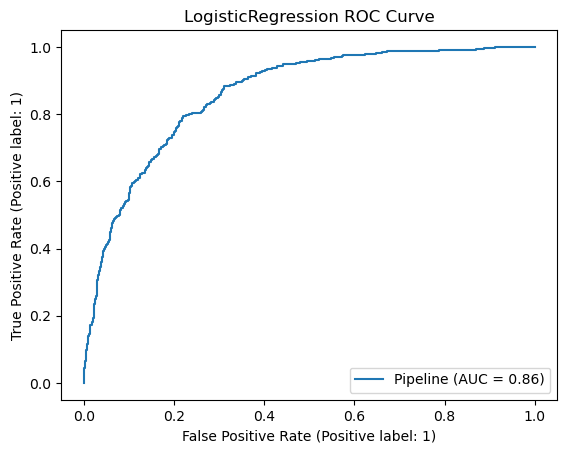

In [17]:
pipe_lr = Pipeline([("transformer", transformer),
                   ("clf", LogisticRegression(class_weight="balanced"))])

y_pred_lr = pipe_lr.fit(X_train, y_train).predict(X_test)

RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test)
plt.title("LogisticRegression ROC Curve")

In [22]:
# LR Scores
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1035
           1       0.52      0.81      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409



In [23]:
def plot_confusion_matrix(y, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

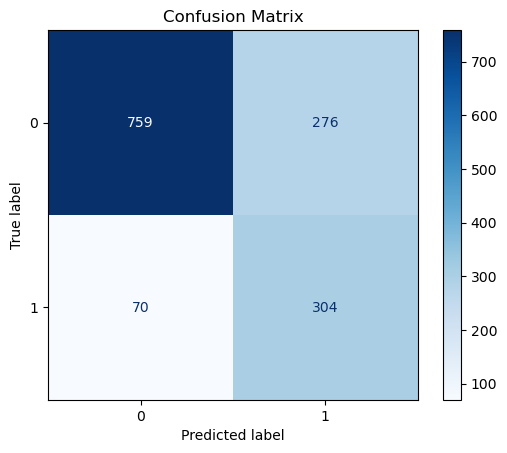

In [24]:
plot_confusion_matrix(y_test, y_pred_lr)

Text(0.5, 1.0, 'CatBoost ROC Curve')

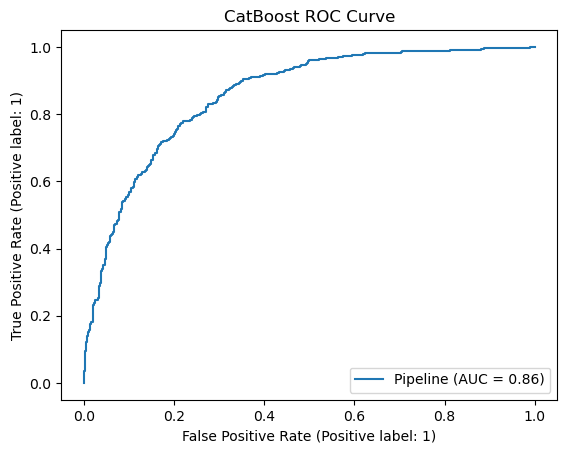

In [18]:
pipe_cat = Pipeline([("transformer", transformer),
                   ("clf", CatBoostClassifier(scale_pos_weight=5,verbose=False))
                   ])

y_pred_cat = pipe_cat.fit(X_train, y_train).predict(X_test)

RocCurveDisplay.from_estimator(pipe_cat, X_test, y_test)
plt.title("CatBoost ROC Curve")

In [20]:
# CatBoost Scores
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      1035
           1       0.50      0.86      0.63       374

    accuracy                           0.74      1409
   macro avg       0.72      0.78      0.71      1409
weighted avg       0.82      0.74      0.75      1409



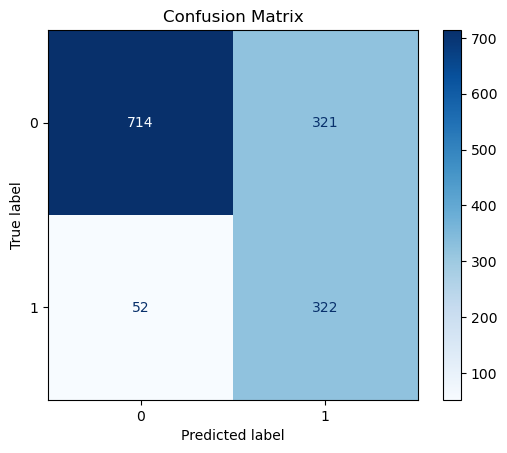

In [25]:
plot_confusion_matrix(y_test, y_pred_cat)

# Results

- The important metric for us in churn problems is the <b>Recall Score (TP/ TP + FN)</b>. Because we need to be able to identify the Churn ones (True Positive) and ensure that the company does not lose profit.
- scale_pos_weight is an XGBoost (eXtreme Gradient Boosting) parameter that is used especially in a classification problem with unbalanced classes. XGBoost is a tree-based learning algorithm for dealing with weighted classes. The scale_pos_weight parameter helps you determine how to weight the instances of the positive class relative to the negative class.
- A classification problem with unbalanced classes refers to a situation where the positive class has fewer instances than the negative class. In such cases, you may want to increase the model's ability to correctly classify the positive class. The scale_pos_weight parameter can correct this imbalance.
- The value of scale_pos_weight specifies how much heavier the negative class should be than the positive class. For example, if the positive class is rarer, you can set scale_pos_weight to reflect the rarity of the positive class relative to the negative class. This can help the model emphasize the positive class more and help you achieve a more balanced result.
- class_weight allow us to adjust class weight. In imbalanced datasets, we can increase the weight of minority class. For example class_weight="balanced" means for both negative and positive class' weights are equal. If we use the parameter like {0:2,1:8} it means that positive class is four time greater than the negative class. 
- class_weight="balanced" captures more true events (higher TRUE recall) but also you are more likely to get false alerts (lower TRUE precision).
- CatBoostClassifier with <b>0.86 Recall Score</b> is the best classifier. After CatBoostClassifier, top 2 is LogisticRegression with <b> 0.81 Recall Score </b>